### **INITIALIZATION**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/PIE')
import MathFunctions
import SimulationFunctions

In [3]:
from math import  *


class Parameters:
    '''
    This class all basic and initial parameters to run the simulation.
    Attention to update the data according to the information and technical characteristics of the components used
    '''
    
    ##Car Features
    Car_length = 0.4      #meters
    Car_width = 0.19      #meters
    Car_maxspeed = 0.3
    Car_minspeed = 0.18 
    Car_speed = 5 #m/s
    radius_margin = 0.01         #Safety margin for vehicle radius (meters)
    Car_radius =sqrt((Car_length/2)**2+(Car_width/2)**2) + radius_margin #Radius of the vehicle. A circle is created with the "car inside" so that nothing goes beyond that circle. 
    Max_acceleration = 0.5
    Max_CurvatureRadious = 30
    Min_CurvatureRadious = 1

    #LIDAR Features
    Lidar_steps=360              #Numbers of data that LIDAR receives in one complete turn
    Lidar_delta=1/2            #Time taken by the sensor to read the N points
    Lidar_stepsize = 360/Lidar_steps       #Angled representation of each LIDAR step
    Lidar_maxdistance = 8     #Maximum distance that the handle can capture an object(meters)

    epsilonmax=45
    tsb=0.1  

    
parameters = Parameters()


In [4]:
import numpy

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 )
        self.data = numpy.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

### **Env**

In [11]:
#Enviroment
import numpy as np
import matplotlib.pyplot as plt
class TrainCar():

    def __init__(self):

        #Variables used only for simulation
        self.Env, self.Position, self.Orientation = SimulationFunctions.MakeEnv()
        self.ep =0;
        #State variables
        self.Speed = parameters.Car_minspeed #m/s
        self.inverse_Radious = 0
        self.LidarData = SimulationFunctions.GetLidarSimulation(self.Env,self.Position,self.Orientation)

        self.done = False
        self.reward = 0
        self.hit, self.miss = 0, 0
        self.Step = 0
        self.red = 0

        self.maxrw = -50

    def run_frame(self, c_rw):
        temp = 0

        # Car moving
        NewPosition, NewOrientation, Angle_Servo = SimulationFunctions.UpdateCar(self.inverse_Radious, self.Speed, self.Position,self.Orientation)

        if ((self.Position[0] < 4 and NewPosition[0] > 4) and self.Position[1] > -2 and self.red != 1):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 1

        if ((self.Position[0] < 6 and NewPosition[0] > 6) and self.Position[1] > -2.5 and self.red != 2):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 2

        if ((self.Position[0] < 8 and NewPosition[0] > 8) and self.Position[1] > -2.5 and self.red != 3):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 3
        
        if ((self.Position[1] >  -3 and NewPosition[1] < -3) and self.Position[0] > 8 and self.red != 4):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 4
        
        if ((self.Position[0] < 10 and NewPosition[0] > 10) and self.Position[1] > -5 and self.red != 5):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 5
        
        if ((self.Position[1] >  -5 and NewPosition[1] < -5) and self.Position[0] > 10 and self.red != 6):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 6

        if ((self.Position[1] >  -7 and NewPosition[1] < -7) and self.Position[0] > 9 and self.red != 7):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 7

        if ((self.Position[0] > 8.5 and NewPosition[0] < 8.5) and self.Position[1] < -7 and self.red != 8):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 8
       
        if ((self.Position[0] > 6 and NewPosition[0] < 6) and self.Position[1] < -6 and self.red != 9):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 9
        
        if ((self.Position[0] > 4 and NewPosition[0] < 4) and self.Position[1] < -5 and self.red != 10):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 10
        
        if ((self.Position[0] > 2 and NewPosition[0] < 2) and self.Position[1] < -5 and self.red != 11):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 11
        
        if ((self.Position[1] <  -5 and NewPosition[1] > -5) and self.Position[0] < 2 and self.red != 12):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 12
        
        if ((self.Position[1] <  -2 and NewPosition[1] > -2) and self.Position[0] < 2 and self.red != 13):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 13
        
        if ((self.Position[0] < 2 and NewPosition[0] > 2) and self.Position[1] > -2 and self.red != 14):
          self.reward += self.Speed*10/(self.Step +1)
          self.Step = 0
          self.red = 14


        self.Orientation = NewOrientation
        self.Position = NewPosition

        #Updating LIDAR
        self.LidarData = SimulationFunctions.GetLidarSimulation(self.Env,self.Position,self.Orientation)
        
        if (1):
          i =0
          n=len(self.Env)
          while i<n:
              nn=len(self.Env[i])
              j=0
              while j<(nn-1):
                  plt.plot([self.Env[i][j][0],self.Env[i][j+1][0]],[self.Env[i][j][1],self.Env[i][j+1][1]],"c-.")
                  plt.scatter(self.Position[0], self.Position[1])
                  j+=1
              i+=1

        # Check car colision
        for i in range(len(self.LidarData)):
            if self.LidarData[i][1] <= parameters.Car_radius:
                self.done = True
                self.reward -= self.Speed * 100 
                if (c_rw > self.maxrw):
                  self.maxrw = c_rw
                  plt.show()
                else:
                  plt.clf()
                break

        


    # ------------------------ AI control ------------------------

    def reset(self):

        #Variables used only for simulation
        self.Env, self.Position, self.Orientation = SimulationFunctions.MakeEnv()
        self.inverse_Radious = 0
        self.Speed = parameters.Car_minspeed #m/s
        self.Step = 0
        self.red = 0
        self.LidarData = SimulationFunctions.GetLidarSimulation(self.Env,self.Position,self.Orientation)

        lista = []
        for i in range(len(self.LidarData)):
          if (i < 90 or i >270):
            lista += [self.LidarData[i][1]]

        #return state
        return [lista + [self.inverse_Radious,self.Speed]]

    def GetCar(self):
      return [self.Position[0]],[self.Position[1]],[self.Orientation]

    def step(self, action, ep, c_rw):
        self.ep = ep;
        self.reward = 0
        self.done = 0 
        self.Step += 1          

        if (action == 0):
          self.inverse_Radious = min(-1, self.inverse_Radious - 0.1)

        if (action == 1):
          self.inverse_Radious = min(-1,self.inverse_Radious - 0.05)

        if (action == 2):
          self.inverse_Radious = min(1, self.inverse_Radious + 0.1)

        if (action == 3):
          self.inverse_Radious = min(1, self.inverse_Radious + 0.05)

        if (action == 4):
           self.inverse_Radious = 0

        self.run_frame(c_rw)
        right = 0
        left = 0
        front = 0
        lista = []
        for i in range(len(self.LidarData)):
          if (i < 30 or i > 330):
            front += self.LidarData[i][1]/30
          if (i > 30 and i <90):  
            right += self.LidarData[i][1]/60
          if (i > 270 and i <330):
            left += self.LidarData[i][1]/60
          if (i < 90 or i >270):
            lista += [self.LidarData[i][1]]

        if (front > left and front > right):
          self.inverse_Radious = 0
       
        elif (right > left):
          self.inverse_Radious = 1
        else:
           self.inverse_Radious = -1

        self.reward += 0.1
        state = [lista + [self.inverse_Radious,self.Speed]]
        return self.reward, state, self.done




### **MODEL**

In [6]:
import numpy as np
import random as rand

from collections import deque

class MemoryBuffer(object):
    """ Memory Buffer Helper class for Experience Replay
    using a double-ended queue or a Sum Tree (for PER)
    """
    def __init__(self, buffer_size, with_per = False):
        """ Initialization
        """
        if(with_per):
            # Prioritized Experience Replay
            self.alpha = 0.6
            self.epsilon = 0.01
            self.buffer = SumTree(buffer_size)
        else:
            # Standard Buffer
            self.buffer = deque()
        self.count = 0
        self.with_per = with_per
        self.buffer_size = buffer_size

    def memorize(self, state, action, reward, done, new_state, error=None):
        """ Save an experience to memory, optionally with its TD-Error
        """

        experience = (state, action, reward, done, new_state)
        if(self.with_per):
            priority = self.priority(error[0])
            self.buffer.add(priority, experience)
            self.count += 1
        else:
            # Check if buffer is already full
            if self.count < self.buffer_size:
                self.buffer.append(experience)
                self.count += 1
            else:
                self.buffer.popleft()
                self.buffer.append(experience)

    def priority(self, error):
        """ Compute an experience priority, as per Schaul et al.
        """
        return (error + self.epsilon) ** self.alpha

    def size(self):
        """ Current Buffer Occupation
        """
        return self.count

    def sample_batch(self, batch_size):
        """ Sample a batch, optionally with (PER)
        """
        batch = []

        # Sample using prorities
        if(self.with_per):
            T = self.buffer.total() // batch_size
            for i in range(batch_size):
                a, b = T * i, T * (i + 1)
                s = rand.uniform(a, b)
                idx, error, data = self.buffer.get(s)
                batch.append((*data, idx))
            idx = np.array([i[5] for i in batch])
        # Sample randomly from Buffer
        elif self.count < batch_size:
            idx = None
            batch = rand.sample(self.buffer, self.count)
        else:
            idx = None
            batch = rand.sample(self.buffer, batch_size)

        # Return a batch of experience
        s_batch = np.array([i[0] for i in batch])
        a_batch = np.array([i[1] for i in batch])
        r_batch = np.array([i[2] for i in batch])
        d_batch = np.array([i[3] for i in batch])
        new_s_batch = np.array([i[4] for i in batch])
        return s_batch, a_batch, r_batch, d_batch, new_s_batch, idx

    def update(self, idx, new_error):
        """ Update priority for idx (PER)
        """
        self.buffer.update(idx, self.priority(new_error))

    def clear(self):
        """ Clear buffer / Sum Tree
        """
        if(self.with_per): self.buffer = SumTree(buffer_size)
        else: self.buffer = deque()
        self.count = 0

In [7]:
import sys
import numpy as np
import keras.backend as K

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, Lambda
from keras.regularizers import l2

import tensorflow as tf
import tensorflow
from keras.layers import Conv2D, MaxPooling2D

def conv_layer(d, k):
    """ Returns a 2D Conv layer, with and ReLU activation
    """
    return Conv2D(d, k, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

def conv_block(inp, d=3, pool_size=(2, 2), k=3):
    """ Returns a 2D Conv block, with a convolutional layer, max-pooling
    """
    conv = conv_layer(d, k)(inp)
    return MaxPooling2D(pool_size=pool_size)(conv)

class Agent:
    """ Agent Class (Network) for DDQN
    """

    def __init__(self, state_dim, action_dim, lr, tau, dueling):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.tau = tau
        self.dueling = dueling
        # Initialize Deep Q-Network
        self.model = self.network(dueling)
        self.model.compile(Adam(lr), 'mse')
        # Build target Q-Network
        self.target_model = self.network(dueling)
        self.target_model.compile(Adam(lr), 'mse')
        self.target_model.set_weights(self.model.get_weights())

    def huber_loss(self, y_true, y_pred):
        return K.mean(K.sqrt(1 + K.square(y_pred - y_true)) - 1, axis=-1)

    def network(self, dueling):
        """ Build Deep Q-Network
        """
        inp = Input((self.state_dim))

        # Determine whether we are dealing with an image input (Atari) or not
        if(len(self.state_dim) > 2):
            inp = Input((self.state_dim[1:]))
            x = conv_block(inp, 32, (2, 2), 8)
            x = conv_block(x, 64, (2, 2), 4)
            x = conv_block(x, 64, (2, 2), 3)
            x = Flatten()(x)
            x = Dense(256, activation='relu')(x)
        else:
            x = Flatten()(inp)
            x = Dense(64, activation='relu')(x)
            x = Dense(64, activation='relu')(x)

        if (dueling):
            # Have the network estimate the Advantage function as an intermediate layer
            x = Dense(self.action_dim + 1, activation='linear')(x)
            x = Lambda(lambda i: K.expand_dims(i[:,0],-1) + i[:,1:] - K.mean(i[:,1:], keepdims=True), output_shape=(self.action_dim,))(x)
        else:
            x = Dense(self.action_dim, activation='linear')(x)
        return Model(inp, x)

    def transfer_weights(self):
        """ Transfer Weights from Model to Target at rate Tau
        """
        W = self.model.get_weights()
        tgt_W = self.target_model.get_weights()
        for i in range(len(W)):
            tgt_W[i] = self.tau * W[i] + (1 - self.tau) * tgt_W[i]
        self.target_model.set_weights(tgt_W)

    def fit(self, inp, targ):
        """ Perform one epoch of training
        """
        self.model.fit(self.reshape(inp), targ, epochs=1, verbose=0)

    def predict(self, inp):
        """ Q-Value Prediction
        """
        inp = numpy.array(inp)
        return self.model.predict(self.reshape(inp))

    def target_predict(self, inp):
        """ Q-Value Prediction (using target network)
        """
        return self.target_model.predict(self.reshape(inp))

    def reshape(self, x):
        if len(x.shape) < 4 and len(self.state_dim) > 2: return np.expand_dims(x, axis=0)
        elif len(x.shape) < 3: return np.expand_dims(x, axis=0)
        else: return x

    def Save(self, path):
        self.model.save_weights(path + '.h5')
        self.model.save(path)

    def load_weights(self, path):
        #self.model.load_weights(path)
        self.model = tf.keras.models.load_model(path)

In [8]:
import sys
import random
import numpy as np

from tqdm import tqdm
from random import random, randrange, sample



class DDQN:
    """ Deep Q-Learning Main Algorithm
    """

    def __init__(self, action_dim, state_dim, args):
        """ Initialization
        """
        # Environment and DDQN parameters
        self.with_per = args.with_per
        self.action_dim = action_dim
        self.state_dim = state_dim
        #
        self.lr = 0.01
        self.gamma = 0.95
        self.epsilon = 0.8
        self.epsilon_decay = 0.99
        self.buffer_size = 20000
        #
        if(len(self.state_dim) < 3):
            self.tau = 1e-2
        else:
            self.tau = 1.0
        # Create actor and critic networks
        self.agent = Agent(self.state_dim, action_dim, self.lr, self.tau, args.dueling)
        # Memory Buffer for Experience Replay
        self.buffer = MemoryBuffer(self.buffer_size, args.with_per)

    def policy_action(self, s):
        """ Apply an espilon-greedy policy to pick next action
        """
        if random() <= self.epsilon and False:
            return randrange(self.action_dim)
        else:
            return np.argmax(self.agent.predict(s)[0])

    def action(self, s):
        """ Apply an espilon-greedy policy to pick next action
        """
        return np.argmax(self.agent.predict(s)[0])

    def train_agent(self, batch_size):
        """ Train Q-network on batch sampled from the buffer
        """
        # Sample experience from memory buffer (optionally with PER)
        s, a, r, d, new_s, idx = self.buffer.sample_batch(batch_size)

        # Apply Bellman Equation on batch samples to train our DDQN
        q = self.agent.predict(s)
        next_q = self.agent.predict(new_s)
        q_targ = self.agent.target_predict(new_s)

        for i in range(s.shape[0]):
            old_q = q[i, a[i]]
            if d[i]:
                q[i, a[i]] = r[i]
            else:
                next_best_action = np.argmax(next_q[i,:])
                q[i, a[i]] = r[i] + self.gamma * q_targ[i, next_best_action]
            if(self.with_per):
                # Update PER Sum Tree
                self.buffer.update(idx[i], abs(old_q - q[i, a[i]]))
        # Train on batch
        self.agent.fit(s, q)
        # Decay epsilon
        self.epsilon *= self.epsilon_decay


    def train(self, env, args):
        """ Main DDQN Training Algorithm
        """

        results = []
        for e in range(args.nb_episodes):
            # Reset episode
            time, cumul_reward, done  = 0, 0, False
            old_state = env.reset()

            while not done:
                if args.render: env.render()
                # Actor picks an action (following the policy)
                a = self.policy_action(old_state)
                # Retrieve new state, reward, and whether the state is terminal
                r,new_state, done = env.step(a,e, cumul_reward)
                # Memorize for experience replay
                self.memorize(old_state, a, r, done, new_state)
                # Update current state
                old_state = new_state
                cumul_reward += r
                time += 1
                # Train DDQN and transfer weights to target network
                if(self.buffer.size() > args.batch_size):
                    self.train_agent(args.batch_size)
                    self.agent.transfer_weights()

            # Display score
            print(str(e)+  "/"+str(args.nb_episodes)+"  Score: " + str(cumul_reward))
            if (e%100 == 0):self.Save_weights('/content/gdrive/MyDrive/PIE/new_modelo')

        return results

    def memorize(self, state, action, reward, done, new_state):
        """ Store experience in memory buffer
        """

        if(self.with_per):
            q_val = self.agent.predict(state)
            q_val_t = self.agent.target_predict(new_state)
            next_best_action = np.argmax(self.agent.predict(new_state))
            new_val = reward + self.gamma * q_val_t[0, next_best_action]
            td_error = abs(new_val - q_val)[0]
        else:
            td_error = 0
        self.buffer.memorize(state, action, reward, done, new_state, td_error)

    def Save_weights(self, path):
        self.agent.Save(path)

    def load_weights(self, path):
        self.agent.load_weights(path)

### **Train**

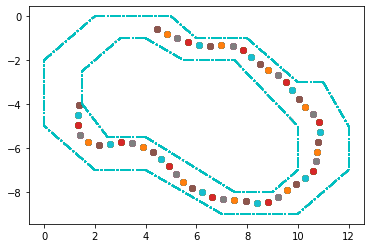

0/5000  Score: -8.708571428571437
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/PIE/new_modelo/assets


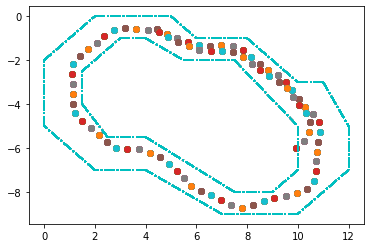

1/5000  Score: -2.0057142857143013
2/5000  Score: -5.358571428571439
3/5000  Score: -16.9
4/5000  Score: -17.0
5/5000  Score: -17.0
6/5000  Score: -17.0
7/5000  Score: -13.75
8/5000  Score: -6.245000000000012
9/5000  Score: -13.69
10/5000  Score: -15.349999999999998
11/5000  Score: -17.599999999999998
12/5000  Score: -17.599999999999998
13/5000  Score: -13.09
14/5000  Score: -12.454999999999998
15/5000  Score: -17.5
16/5000  Score: -15.54
17/5000  Score: -15.45
18/5000  Score: -13.132857142857144
19/5000  Score: -16.9
20/5000  Score: -10.575714285714291
21/5000  Score: -15.54
22/5000  Score: -13.349999999999998
23/5000  Score: -7.3500000000000085
24/5000  Score: -17.0
25/5000  Score: -16.9
26/5000  Score: -17.142857142857142
27/5000  Score: -17.142857142857142
28/5000  Score: -17.142857142857142
29/5000  Score: -17.0
30/5000  Score: -17.142857142857142
31/5000  Score: -17.142857142857142
32/5000  Score: -17.4
33/5000  Score: -17.4
34/5000  Score: -17.4
35/5000  Score: -17.5
36/5000  Sc

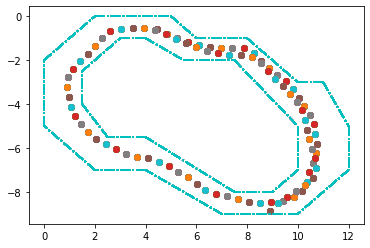

60/5000  Score: -0.6707142857142863
61/5000  Score: -16.799999999999997
62/5000  Score: -16.2
63/5000  Score: -10.44785714285715
64/5000  Score: -16.799999999999997
65/5000  Score: -6.0085714285714396
66/5000  Score: -11.37571428571429
67/5000  Score: -14.7
68/5000  Score: -14.089999999999996
69/5000  Score: -6.947857142857153
70/5000  Score: -11.37571428571429
71/5000  Score: -5.450714285714296
72/5000  Score: -10.535714285714292
73/5000  Score: -10.475714285714291
74/5000  Score: -10.437857142857148
75/5000  Score: -15.639999999999999
76/5000  Score: -12.132857142857144
77/5000  Score: -4.290714285714298
78/5000  Score: -10.63571428571429
79/5000  Score: -12.232857142857146
80/5000  Score: -5.830714285714297
81/5000  Score: -12.272857142857145
82/5000  Score: -16.2


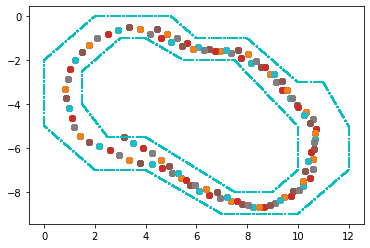

83/5000  Score: 0.7407142857142937
84/5000  Score: -6.2935714285714415
85/5000  Score: -11.507857142857144
86/5000  Score: -12.292857142857144
87/5000  Score: -11.432857142857145
88/5000  Score: -10.515714285714292
89/5000  Score: -16.4
90/5000  Score: -1.0164285714285803
91/5000  Score: -10.475714285714291
92/5000  Score: -5.813571428571441
93/5000  Score: -5.523571428571444
94/5000  Score: -10.43571428571429
95/5000  Score: -10.375714285714292
96/5000  Score: -15.339999999999998
97/5000  Score: -5.512857142857156
98/5000  Score: -12.232857142857146
99/5000  Score: -10.508571428571434
100/5000  Score: -11.37571428571429
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/PIE/new_modelo/assets
101/5000  Score: -9.858571428571436
102/5000  Score: -10.405714285714291
103/5000  Score: -15.649999999999999
104/5000  Score: -12.690000000000001
105/5000  Score: -10.518571428571434
106/5000  Score: -5.5728571428571545
107/5000  Score: -14.879999999999999
108/5000  Score: -11.97285714285

KeyboardInterrupt: ignored

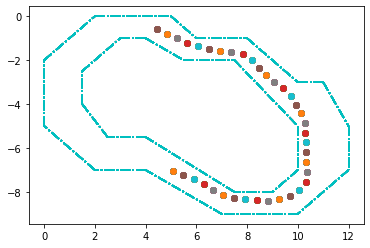

In [15]:
  """ Load and display pre-trained model in OpenAI Gym Environment
"""

import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf


from keras.utils import to_categorical



def parse_args(args):
    """ Parse arguments from command line input
    """
    parser = argparse.ArgumentParser(description='Training parameters')
    #
    parser.add_argument('--type', type=str, default='DDQN',help="Algorithm to train from {A2C, A3C, DDQN, DDPG}")
    parser.add_argument('--is_atari', dest='is_atari', action='store_true', help="Atari Environment")
    parser.add_argument('--with_PER', dest='with_per', action='store_true', help="Use Prioritized Experience Replay (DDQN + PER)")
    parser.add_argument('--dueling', dest='dueling', action='store_true', help="Use a Dueling Architecture (DDQN)")
    #
    parser.add_argument('--nb_episodes', type=int, default=5000, help="Number of training episodes")
    parser.add_argument('--batch_size', type=int, default=64, help="Batch size (experience replay)")
    parser.add_argument('--consecutive_frames', type=int, default=4, help="Number of consecutive frames (action repeat)")
    parser.add_argument('--training_interval', type=int, default=30, help="Network training frequency")
    parser.add_argument('--n_threads', type=int, default=8, help="Number of threads (A3C)")
    #
    parser.add_argument('--gather_stats', dest='gather_stats', action='store_true',help="Compute Average reward per episode (slower)")
    parser.add_argument('--render', dest='render', action='store_true', help="Render environment while training")
    parser.add_argument('--env', type=str, default='BreakoutNoFrameskip-v4',help="OpenAI Gym Environment")
    parser.add_argument('--gpu', type=int, default=0, help='GPU ID')
    #
    parser.set_defaults(render=False)
    parser.add_argument("-f", "--file", required=False) 
    return parser.parse_args(args)

def main(args=None):

    # Parse arguments
    if args is None:
        args = sys.argv[1:]
    args = parse_args(args)


    env = TrainCar()
    env.reset()
    state_dim = (1,181)
    action_dim = 6

    # Pick algorithm to train
    algo = DDQN(action_dim, state_dim, args)
    algo.load_weights('/content/gdrive/MyDrive/PIE/modelo')
    #algo.load_weights(args.model_path)

    stats = algo.train(env, args)
    algo.save_weights('/content/gdrive/MyDrive/PIE/modelo_new')

    

if __name__ == "__main__":
    main()

### **SIMULATION**

In [9]:
import argparse
def parse_args(args):
    """ Parse arguments from command line input
    """
    parser = argparse.ArgumentParser(description='Training parameters')
    #
    parser.add_argument('--type', type=str, default='DDQN',help="Algorithm to train from {A2C, A3C, DDQN, DDPG}")
    parser.add_argument('--is_atari', dest='is_atari', action='store_true', help="Atari Environment")
    parser.add_argument('--with_PER', dest='with_per', action='store_true', help="Use Prioritized Experience Replay (DDQN + PER)")
    parser.add_argument('--dueling', dest='dueling', action='store_true', help="Use a Dueling Architecture (DDQN)")
    #
    parser.add_argument('--nb_episodes', type=int, default=5000, help="Number of training episodes")
    parser.add_argument('--batch_size', type=int, default=64, help="Batch size (experience replay)")
    parser.add_argument('--consecutive_frames', type=int, default=4, help="Number of consecutive frames (action repeat)")
    parser.add_argument('--training_interval', type=int, default=30, help="Network training frequency")
    parser.add_argument('--n_threads', type=int, default=8, help="Number of threads (A3C)")
    #
    parser.add_argument('--gather_stats', dest='gather_stats', action='store_true',help="Compute Average reward per episode (slower)")
    parser.add_argument('--render', dest='render', action='store_true', help="Render environment while training")
    parser.add_argument('--env', type=str, default='BreakoutNoFrameskip-v4',help="OpenAI Gym Environment")
    parser.add_argument('--gpu', type=int, default=0, help='GPU ID')
    #
    parser.set_defaults(render=False)
    parser.add_argument("-f", "--file", required=False) 
    return parser.parse_args(args)

def Simulate(times):

    Result = [[],[],[]]

    args = None
    # Parse arguments
    if args is None:
        args = sys.argv[1:]
    args = parse_args(args)


    state_dim = (1,181)
    action_dim = 6
    algo = DDQN(action_dim, state_dim, args)
    algo.load_weights('/content/gdrive/MyDrive/PIE/new_modelo')


    env = TrainCar()
    old_state, i = env.reset(), 0
    done = False

    while not done and i < times:
      a = algo.action(old_state)
      print(a)
      r,old_state, done = env.step(a,3,-100)

      Position = [[],[]]
      Position[0],Position[1],Orientation = env.GetCar()

      Result[0] += Position[0]
      Result[1] += Position[1]
      Result[2] += Orientation

      i += 1
          

    return Result
    




0
2
2
2
3
2
3
2
2
0
2
0
3
3
3
3
3
2
2
0
2
0
2
0
2
0
2
2
2
0
END Simulation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

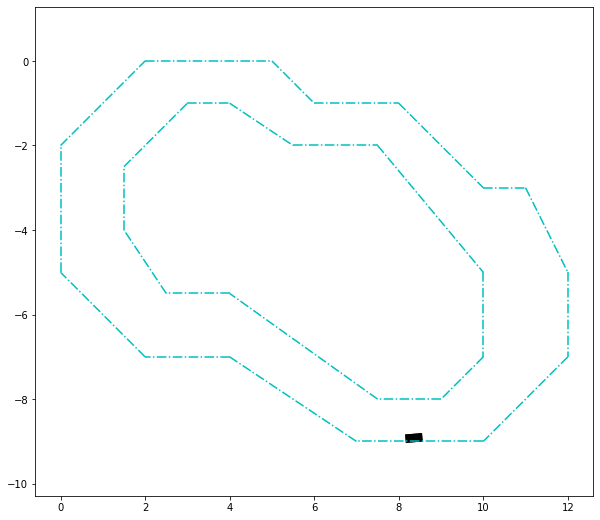

In [12]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from IPython.display import HTML




#making all the enviroment
RaceTrack ,l ,o = SimulationFunctions.MakeEnv() 


#simulation
Car1x,Car1y,Car1ori = Simulate(400)
print("END Simulation")
    
#Plotting
fig = plt.figure(figsize=(10, 9))
plt.axis('equal')

#Racetrack
i =0
n=len(RaceTrack)
while i<n:
    nn=len(RaceTrack[i])
    j=0
    while j<(nn-1):
        plt.plot([RaceTrack[i][j][0],RaceTrack[i][j+1][0]],[RaceTrack[i][j][1],RaceTrack[i][j+1][1]],"c-.")
        j+=1
    i+=1
    
    
    
ax = fig.add_subplot(111)


patch1 = patches.Rectangle((0, 0), 0, 0, fc='k')
point1, = ax.plot([], [],'ko')

def init():
    ax.add_patch(patch1)
    point1.set_data([], [])
    return (patch1,point1)

def animate(i):
    patch1.set_width(0.4)
    patch1.set_height(0.2)
    patch1.set_xy([Car1x[i], Car1y[i]])
    patch1.angle = Car1ori[i]
    
    return (patch1,point1)

anim = animation.FuncAnimation(fig, animate,
                               init_func=init,
                               frames=len(Car1x),
                               interval=100,
                               blit=True)


HTML(anim.to_html5_video())
    
    
    